In [35]:
import os
import pandas as pd
import geopandas as gpd
import datetime as dt
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns

DROOT = os.path.join('./1-data/')
drootf = lambda path: os.path.join(DROOT, path)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

/Users/ivo/mambaforge/envs/thesis-env/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


(4053, 41)


,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,utm_centroid
0,1184.0,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (121274.166 478898.955)


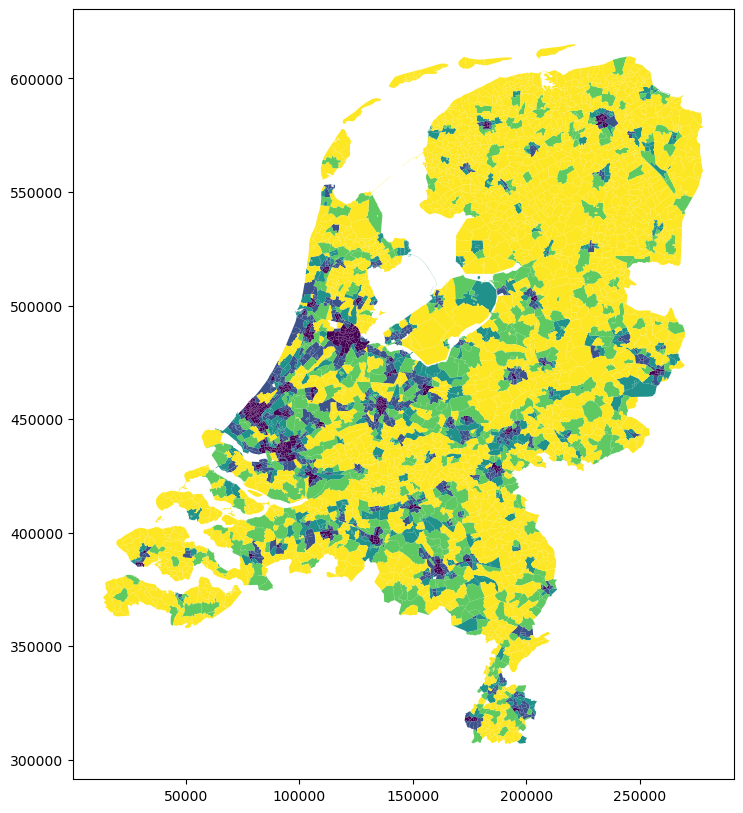

In [2]:
# Load postcodes
postcodes = gpd.read_file(drootf('2023-CBS_pc4_2022_v1/cbs_pc4_2022_v1.gpkg'))
postcodes.postcode4 = postcodes.postcode4.astype(float)
postcodes['kmarea'] = postcodes.to_crs(postcodes.estimate_utm_crs()).area / 10e6 # to Km2
postcodes['utm_centroid'] = postcodes.to_crs(postcodes.estimate_utm_crs()).centroid.to_crs(postcodes.crs)
postcodes = postcodes[postcodes.stedelijkheid > 0] # Some regions with harbours
pc_reduced = postcodes[['postcode4', 'stedelijkheid', 'geometry', 'utm_centroid']]

ax = postcodes.plot(figsize=(10,10), column='stedelijkheid')
print(postcodes.shape)
postcodes.head(1)

,STN,FHVEC,FG,TG,DR,RH,DATE,NAME,geometry
1826,215,58.0,64.0,68.0,35.0,37.0,2018-01-01,Voorschoten,POINT Z (4.43700 52.14100 -1.10000)
1827,215,48.0,63.0,70.0,69.0,54.0,2018-01-02,Voorschoten,POINT Z (4.43700 52.14100 -1.10000)
1828,215,110.0,114.0,86.0,29.0,140.0,2018-01-03,Voorschoten,POINT Z (4.43700 52.14100 -1.10000)
1829,215,69.0,74.0,82.0,12.0,6.0,2018-01-04,Voorschoten,POINT Z (4.43700 52.14100 -1.10000)
1830,215,44.0,45.0,61.0,23.0,56.0,2018-01-05,Voorschoten,POINT Z (4.43700 52.14100 -1.10000)
...,...,...,...,...,...,...,...,...,...
85817,391,31.0,32.0,51.0,0.0,0.0,2022-12-27,Arcen,POINT Z (6.19700 51.49800 19.50000)
85818,391,47.0,48.0,91.0,58.0,30.0,2022-12-28,Arcen,POINT Z (6.19700 51.49800 19.50000)
85819,391,49.0,50.0,94.0,29.0,50.0,2022-12-29,Arcen,POINT Z (6.19700 51.49800 19.50000)
85820,391,37.0,41.0,86.0,38.0,21.0,2022-12-30,Arcen,POINT Z (6.19700 51.49800 19.50000)


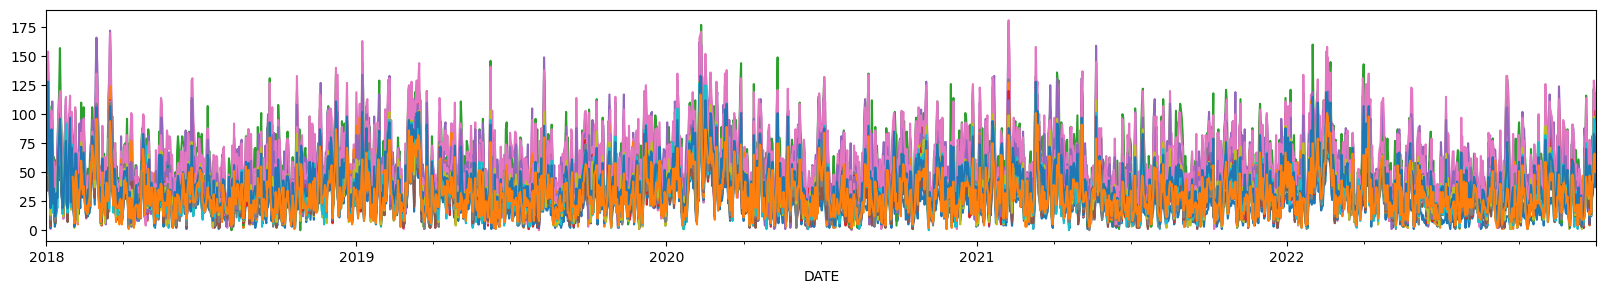

In [3]:
# Load weather stations
stations = pd.read_csv(drootf('./knmi/knmi-stations.csv'), index_col='STN')
stations['geometry'] = gpd.points_from_xy(stations.LON, stations.LAT, stations.ALT, crs='EPSG:4326')
stations = gpd.GeoDataFrame(stations)

# Load weather data
knmi_result = pd.read_csv(drootf('./knmi/result.txt'), skiprows=61, skipinitialspace = True)
knmi_result = knmi_result.rename(columns={'# STN': 'STN'})
knmi_result['DATE'] = pd.to_datetime(knmi_result.YYYYMMDD, format="%Y%m%d")
knmi_result = knmi_result.merge(stations[['NAME', 'geometry']], on='STN')
knmi_result = knmi_result.dropna(how='any').drop(columns=['YYYYMMDD'])

# Visualize
knmi_result.sort_values('DATE').pivot_table('FHVEC', 'DATE', 'NAME').plot(figsize=(20,3), legend=False)
knmi_result

/Users/ivo/mambaforge/envs/thesis-env/lib/python3.11/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ivo/mambaforge/envs/thesis-env/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,utm_centroid,index_knmi,LON,LAT,ALT,NAME
0,1184.0,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704),240,4.79,52.318,-3.3,Schiphol
6,1505.0,6605,3300,3305,1340,730,2045,1650,840,40,0,20,10,20,2950,1120,635,425,770,2.2,2795,475,1135,60,115,20,180,695,120,1365,40,60,1545,55,273,855,2161,2,"MULTIPOLYGON (((117338.980 493436.228, 117308....",0.403228,POINT (4.84916 52.42520),240,4.79,52.318,-3.3,Schiphol


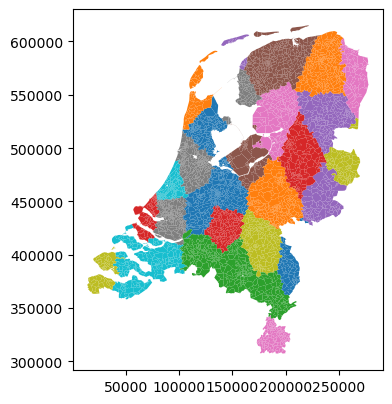

In [21]:
# Filter stations df to only have complete stations, and attach those stations to postcode4 zones.
stations_f = stations[stations.index.isin(knmi_result.STN.unique())]
postcodes_knmi = postcodes.set_geometry('utm_centroid').to_crs(stations_f.crs).sjoin_nearest(stations_f, rsuffix='knmi')
fig, ax = plt.subplots(figsize=(4,8))
postcodes_knmi.set_geometry('geometry').plot(column='NAME', ax=ax)
postcodes_knmi.head(2)

In [28]:
KHvm_transl = {
    "1": "Personenauto - bestuurder",
    "2": "Personenauto - passagier",
    "3": "Trein",
    "4": "Bus/tram/metro",
    "5": "Fiets",
    "6": "Te voet",
    "7": "Overig",
}

In [37]:
odin_df = pd.concat([
    pd.read_csv(drootf('ODiN/ODiN2021_Databestand.csv'), sep=';', encoding= 'unicode_escape'),
    # pd.read_csv(drootf('ODiN/ODiN2022_Databestand.csv'), sep=';', encoding= 'unicode_escape'),
    # pd.read_csv(drootf('ODiN/ODiN2018_Databestand_v2.0.csv'), sep=';', encoding= 'unicode_escape'),
    # pd.read_csv(drootf('ODiN/ODiN2019_Databestand_v2.0.csv'), sep=';', encoding= 'unicode_escape')
])
odin_df = odin_df.drop_duplicates('VerplID')
odin_df['ReportDate'] = pd.to_datetime(dict(year=odin_df.Jaar, month=odin_df.Maand, day=odin_df.Dag))
odin_df['KHvm_transl'] = odin_df.KHvm.replace(KHvm_transl)
odin_df.head(2)

,OP,OPID,Steekproef,Mode,HHPers,HHSam,HHPlOP,HHLft1,HHLft2,HHLft3,HHLft4,WoPC,WoGem,Sted,GemGr,Prov,Corop,BuurtAdam,MRA,MRDH,Utr,Geslacht,Leeftijd,KLeeft,Herkomst,BetWerk,OnbBez,MaatsPart,Opleiding,HHBestInkG,HHGestInkG,HHLaagInk,HHSocInk,HHWelvG,HHRijbewijsAu,HHRijbewijsMo,HHRijbewijsBr,OPRijbewijsAu,OPRijbewijsMo,OPRijbewijsBr,HHAuto,HHAutoL,OPAuto,BrandstofPa1,XBrandstofPa1,BrandstofEPa1,BouwjaarPa1,KBouwjaarPa1,KGewichtPa1,TenaamPa1,BrandstofPa2,XBrandstofPa2,BrandstofEPa2,BouwjaarPa2,KBouwjaarPa2,KGewichtPa2,TenaamPa2,BrandstofPaL,XBrandstofPaL,BrandstofEPaL,BouwjaarPaL,KBouwjaarPaL,KGewichtPaL,HHMotor,OPMotor,HHBrom,OPBrom,HHSnor,OPSnor,HHEFiets,HHBezitVm,OPBezitVm,FqLopen,FqNEFiets,FqEFiets,FqBTM,FqTrein,FqAutoB,FqAutoP,FqBrSnor,FqMotor,OVStKaart,Jaar,Maand,Week,Dag,Weekdag,Feestdag,Weggeweest,RedenNW,RedenNWZ,RedenNWW,RedenNWB,AantVpl,AantOVVpl,AantSVpl,EFiets,AutoEig,AutoHhL,AutoLWg,AutoLPl,AutoBed,AutoDOrg,AutoDPart,AutoDBek,AutoLeen,AutoHuur,AutoAnd,ByzDag,ByzAdr,ByzVvm,ByzTyd,ByzDuur,ByzRoute,ByzReden,ReisduurOP,AfstandOP,AfstandSOP,Verpl,VerplID,VerplNr,Toer,AantRit,Doel,MotiefV,KMotiefV,MeerWink,AardWerk,VertLoc,VertGeb,VertPC,VertPCBL,VertGem,VertProv,VertCorop,VertMRA,VertMRDH,VertUtr,AankGeb,AankPC,AankPCBL,AankGem,AankProv,AankCorop,AankMRA,AankMRDH,AankUtr,PCG,GemG,PCBLG,AfstV,KAfstV,Hvm,HvmRol,KHvm,VertUur,VertMin,KVertTijd,AankUur,AankMin,Reisduur,KReisduur,ActDuur,Kind6,VolgWerk,SAantAdr,SDezPlts,SPlaats1,SPlaats2,SPlaats3,SPlaats4,SPlaats5,AfstS,AfstSBL,SVvm1,SVvm2,SVvm3,SVvm4,SBegUur,SBegMin,SEindUur,SEindMin,CorrVerpl,GehBLVer,Rit,RitID,RitNr,AfstR,AfstRBL,KAfstR,Rvm,RvmRol,RAantIn,KRvm,RVertUur,RVertMin,RAankUur,RAankMin,RReisduur,RReisduurBL,RVertStat,RAankStat,RTSamen,RCorrSnelh,RVliegVer,FactorH,FactorP,FactorV,ReportDate,KHvm_transl
0,1,62344107254,1,1,3,3,3,1,0,0,2,1363,34,2,7,5,40,0,15,18,21,2,38,9,1,3,0,2,4,10,10,8,9,9,2,0,2,1,0,1,2,1,1,2,0,0,2011,2,3,1,7,7,6,9995,9,7,3,1,0,0,2018,4,3,0,0,0,0,0,0,0,2,3,9,3,5,5,5,2,2,5,9,0,2021,1,2,17,1,0,1,0,0,0,0,2,0,0,5,2,2,1,2,2,2,2,2,2,2,2,2,3,3,3,3,3,11,30,150,0,1,6234410725401,1,0,1,9,8,6,3,12,1,0,1363.0,1.0,34,5,40,15,18,21,0,1319.0,1.0,34,5,40,15,18,21,0.0,0,0.0,75,7,1,2,2,16,0,9,16,15,15,4,210,1,9,#NULL!,#NULL!,NaN,NaN,NaN,NaN,NaN,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,0,0,1,623441072540101,1,75,0,7,1,2,3,2,16,0,16,15,15,0,0.0,0.0,13,0,0,94,188,68606,2021-01-17,Personenauto - passagier
1,0,62344107254,1,1,3,3,3,1,0,0,2,1363,34,2,7,5,40,0,15,18,21,2,38,9,1,3,0,2,4,10,10,8,9,9,2,0,2,1,0,1,2,1,1,2,0,0,2011,2,3,1,7,7,6,9995,9,7,3,1,0,0,2018,4,3,0,0,0,0,0,0,0,2,3,9,3,5,5,5,2,2,5,9,0,2021,1,2,17,1,0,1,0,0,0,0,2,0,0,5,2,2,1,2,2,2,2,2,2,2,2,2,3,3,3,3,3,11,30,150,0,1,6234410725402,2,0,1,1,8,6,3,12,4,0,1319.0,1.0,34,5,40,15,18,21,0,1363.0,1.0,34,5,40,15,18,21,0.0,0,0.0,75,7,1,2,2,19,45,12,20,0,15,4,#NULL!,1,9,#NULL!,#NULL!,NaN,NaN,NaN,NaN,NaN,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,0,0,1,623441072540201,1,75,0,7,1,2,3,2,19,45,20,0,15,0,0.0,0.0,13,0,0,94,188,68606,2021-01-17,Personenauto - passagier


In [38]:
odin_df_r = odin_df.merge(postcodes_knmi, left_on='VertPC', right_on='postcode4')
odin_df_r = odin_df_r.merge(knmi_result, left_on=['ReportDate', 'index_knmi'], right_on=['DATE', 'STN'])
odin_df_r

,OP,OPID,Steekproef,Mode,HHPers,HHSam,HHPlOP,HHLft1,HHLft2,HHLft3,HHLft4,WoPC,WoGem,Sted,GemGr,Prov,Corop,BuurtAdam,MRA,MRDH,Utr,Geslacht,Leeftijd,KLeeft,Herkomst,BetWerk,OnbBez,MaatsPart,Opleiding,HHBestInkG,HHGestInkG,HHLaagInk,HHSocInk,HHWelvG,HHRijbewijsAu,HHRijbewijsMo,HHRijbewijsBr,OPRijbewijsAu,OPRijbewijsMo,OPRijbewijsBr,HHAuto,HHAutoL,OPAuto,BrandstofPa1,XBrandstofPa1,BrandstofEPa1,BouwjaarPa1,KBouwjaarPa1,KGewichtPa1,TenaamPa1,BrandstofPa2,XBrandstofPa2,BrandstofEPa2,BouwjaarPa2,KBouwjaarPa2,KGewichtPa2,TenaamPa2,BrandstofPaL,XBrandstofPaL,BrandstofEPaL,BouwjaarPaL,KBouwjaarPaL,KGewichtPaL,HHMotor,OPMotor,HHBrom,OPBrom,HHSnor,OPSnor,HHEFiets,HHBezitVm,OPBezitVm,FqLopen,FqNEFiets,FqEFiets,FqBTM,FqTrein,FqAutoB,FqAutoP,FqBrSnor,FqMotor,OVStKaart,Jaar,Maand,Week,Dag,Weekdag,Feestdag,Weggeweest,RedenNW,RedenNWZ,RedenNWW,RedenNWB,AantVpl,AantOVVpl,AantSVpl,EFiets,AutoEig,AutoHhL,AutoLWg,AutoLPl,AutoBed,AutoDOrg,AutoDPart,AutoDBek,AutoLeen,AutoHuur,AutoAnd,ByzDag,ByzAdr,ByzVvm,ByzTyd,ByzDuur,ByzRoute,ByzReden,ReisduurOP,AfstandOP,AfstandSOP,Verpl,VerplID,VerplNr,Toer,AantRit,Doel,MotiefV,KMotiefV,MeerWink,AardWerk,VertLoc,VertGeb,VertPC,VertPCBL,VertGem,VertProv,VertCorop,VertMRA,VertMRDH,VertUtr,AankGeb,AankPC,AankPCBL,AankGem,AankProv,AankCorop,AankMRA,AankMRDH,AankUtr,PCG,GemG,PCBLG,AfstV,KAfstV,Hvm,HvmRol,KHvm,VertUur,VertMin,KVertTijd,AankUur,AankMin,Reisduur,KReisduur,ActDuur,Kind6,VolgWerk,SAantAdr,SDezPlts,SPlaats1,SPlaats2,SPlaats3,SPlaats4,SPlaats5,AfstS,AfstSBL,SVvm1,SVvm2,SVvm3,SVvm4,SBegUur,SBegMin,SEindUur,SEindMin,CorrVerpl,GehBLVer,Rit,RitID,RitNr,AfstR,AfstRBL,KAfstR,Rvm,RvmRol,RAantIn,KRvm,RVertUur,RVertMin,RAankUur,RAankMin,RReisduur,RReisduurBL,RVertStat,RAankStat,RTSamen,RCorrSnelh,RVliegVer,FactorH,FactorP,FactorV,ReportDate,KHvm_transl,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry_x,kmarea,utm_centroid,index_knmi,LON,LAT,ALT,NAME_x,STN,FHVEC,FG,TG,DR,RH,DATE,NAME_y,geometry_y
0,1,62344107254,1,1,3,3,3,1,0,0,2,1363,34,2,7,5,40,0,15,18,21,2,38,9,1,3,0,2,4,10,10,8,9,9,2,0,2,1,0,1,2,1,1,2,0,0,2011,2,3,1,7,7,6,9995,9,7,3,1,0,0,2018,4,3,0,0,0,0,0,0,0,2,3,9,3,5,5,5,2,2,5,9,0,2021,1,2,17,1,0,1,0,0,0,0,2,0,0,5,2,2,1,2,2,2,2,2,2,2,2,2,3,3,3,3,3,11,30,150,0,1,6234410725401,1,0,1,9,8,6,3,12,1,0,1363.0,1.0,34,5,40,15,18,21,0,1319.0,1.0,34,5,40,15,18,21,0.0,0,0.0,75,7,1,2,2,16,0,9,16,15,15,4,210,1,9,#NULL!,#NULL!,NaN,NaN,NaN,NaN,NaN,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,0,0,1,623441072540101,1,75,0,7,1,2,3,2,16,0,16,15,15,0,0.0,0.0,13,0,0,94,188,68606,2021-01-17,Personenauto - passagier,1363.0,15375,7570,7800,3895,1420,6595,2660,805,40,0,30,10,20,6540,2225,1425,835,2055,2.3,6425,-99997,-99997,-99997,-99997,-99997,-99997,3950,2475,3365,60,40,1415,215,359,990,1567,2,"MULTIPOLYGON (((137535.799 486541.372, 137539....",0.361653,POINT (5.14876 52.35

In [46]:
pd.qcut(odin_df_r.RH, 10, duplicates='drop')

0          (15.0, 35.0]
1          (15.0, 35.0]
2          (15.0, 35.0]
3          (15.0, 35.0]
4          (15.0, 35.0]
              ...      
167520    (-1.001, 0.0]
167521     (35.0, 71.0]
167522       (0.0, 1.0]
167523     (15.0, 35.0]
167524    (71.0, 920.0]
Name: RH, Length: 167525, dtype: category
Categories (7, interval[float64, right]): [(-1.001, 0.0] < (0.0, 1.0] < (1.0, 5.0] < (5.0, 15.0] < (15.0, 35.0] < (35.0, 71.0] < (71.0, 920.0]]

/Users/ivo/mambaforge/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ivo/mambaforge/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ivo/mambaforge/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ivo/mambaforge/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='RH', ylabel='TG'>

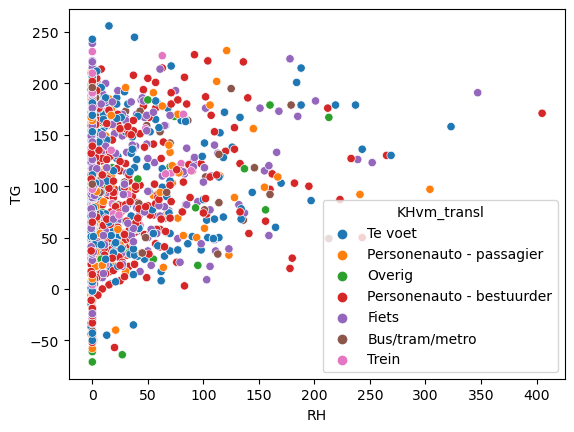

In [36]:
sns.scatterplot(data=odin_df_r.sample(2000), x=odin_df_r.RH.cut(5), y='TG', hue='KHvm_transl')